__BIOBSS - PPG Signal Processing__

_This notebook includes guidelines to help using BIOBSS for PPG signal processing and feature extraction._

In [1]:
#Import BIOBSS and other required packages

import biobss
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

c:\Users\ipek.karakus\.conda\envs\biolib\lib\site-packages\plotly_resampler\aggregation\aggregators.py:24: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


# Table of Contents
1. [PPG Sample Data](#sampledata)<br>
2. [PPG Signal Preprocessing](#ppg_pre)<br>
    2.1. [Filtering](#ppg_filter)<br>
    2.2. [Peak Detection](#ppg_peak)<br>
4. [PPG Signal Quality Assessment](#ppg_sqa)<br>
    4.1. [Clipping and Flatline Detection](#ppg_cf)<br>
    4.2. [Physiological and Morphological Limits](#ppg_pm)<br>
    4.3. [Template Matching](#ppg_tm)<br>
5. [PPG Feature Extraction](#ppg_features)<br>

### __PPG Sample Data__
<a id="sampledata"></a>

PPG sample data is provided as a csv file in BIOBSS\sample data. The data file contains 100 PPG segments of 10-seconds length. The sampling rate is 64 Hz for all segments.

In [2]:
#Load the sample data
data_dir = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir),"sample_data")
filename='ppg_sample_data.csv'
data=pd.read_csv(os.path.join(data_dir,filename), header=None)

#Select the first segment to be used in the examples
fs=64
L=10
sig=np.asarray(data.iloc[0,:])  


### __PPG Signal Preprocessing__
<a id="ppg_pre"></a>

#### __Filtering__
<a id="ppg_filter"></a>

BIOBSS provides a filtering function which uses Scipy. This function can be used to implement Butterworth filter by defining the filter parameters (filter type, filter order, cutoff frequencies) as shown below. 

In [3]:
#Filter PPG signal by defining the filter parameters
f_sig= biobss.preprocess.filter_signal(sig,sampling_rate=fs,filter_type='bandpass',N=2,f_lower=0.5,f_upper=5)

As an alternative, predefined filters can be used for each signal type. In order to use this option for PPG signal, signal_type should be selected as 'PPG'. 

In [ ]:
#Filter PPG signal by using predefined filters
filtered_ppg = biobss.preprocess.filter_signal(sig, sampling_rate=fs, signal_type='PPG', method='bandpass')

#### __Peak Detection__
<a id="ppg_peak"></a>

BIOBSS provides a peak detection function with different alternatives for the peak detection method. These methods are appropriate for PPG signal, however the parameters should be selected properly if the second peak (diastolic peak) is observable in the signal. The ___peak_detection___ function returns a dictionary including peak locations, peak amplitudes, trough locations and trough amplitudes.

In [4]:
#Detect peaks using 'peakdet' method (delta=0.01). Delta parameter should be adjusted related to the amplitude of the signal.

info=biobss.preprocess.peak_detection(f_sig,fs,'peakdet',delta=0.01)

locs_peaks=info['Peak_locs']
peaks=info['Peaks']
locs_onsets=info['Trough_locs']
onsets=info['Troughs']

In case of PPG waveform has low amplitude, PPG beats can be detected more accurately from the rising edge of the signal, instead of peaks. BIOBSS provides the function ___ppg_beats___ for this purpose. The function calculates the first derivative of the PPG signal (velocity plethysmogram - VPG) and detects peaks of VPG. The peaks of VPG signal corresponds maximum slope point on the rising edge of the PPG signal. Note that, the ___ppg_beats___ function returns only peak locations and __delta__ parameter should be adjusted considering the amplitude of VPG signal.

In [ ]:
locs_peaks=biobss.ppgtools.ppg_beats(sig, sampling_rate=fs, method='peakdet', delta=0.005)
peaks=sig[locs_peaks]
locs_onsets=info['Trough_locs']
onsets=info['Troughs']

For further analysis, a peak control step is required to prevent errors resulting from incorrect peak detection results (missing or dupliciate peaks). The ___peak_control___ function checks the relative locations of peaks and troughs, ensuring only a single peak is located between consecutive troughs.

In [5]:
#Correct the peak detection results by considering the order of peaks and troughs
info=biobss.ppgtools.peak_control(peaks_locs=locs_peaks, peaks_amp=peaks, troughs_locs=locs_onsets, troughs_amp=onsets)

locs_peaks=info['Peak_locs']
peaks=info['Peaks']
locs_onsets=info['Trough_locs']
onsets=info['Troughs']

BIOBSS provides plotting functions specific to each signal type. In order to plot ACC signals, ___plot_ppg___ function can be used. The signals and peaks should be provided as dictionaries, and the keys should be selected as in documentation. The plots can be generated either using __Matplotlib__ or __Plotly__. 

In [6]:
#Generate inputs as dictionaries
signals={'Raw': sig, 'Filtered': f_sig}
peaks={'Peaks': {'Location':locs_peaks, 'Amplitude':peaks}, 'Onsets': {'Location':locs_onsets, 'Amplitude':onsets}}

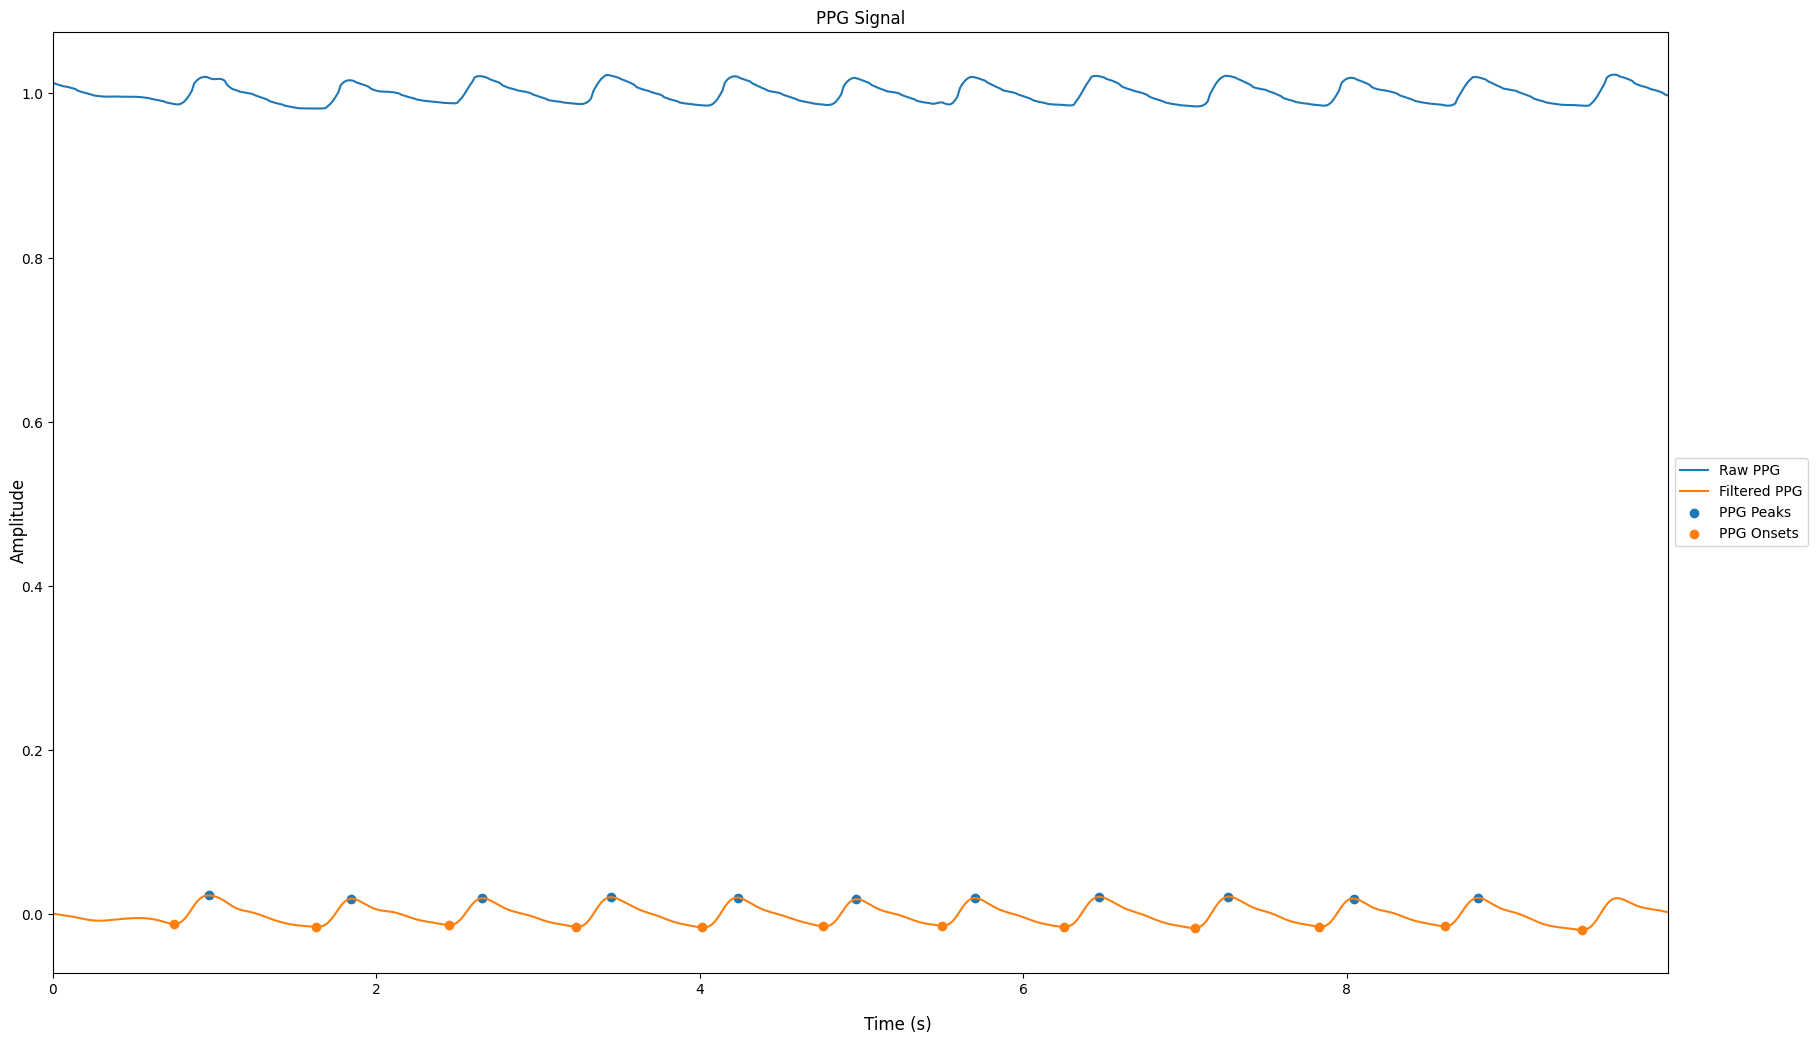

In [7]:
#Plot PPG Signal using Matplotlib
biobss.ppgtools.plot_ppg(signals=signals, peaks=peaks, sampling_rate=fs, show_peaks=True)

In [8]:
#Plot PPG signal using Plotly
biobss.ppgtools.plot_ppg(signals=signals, peaks=peaks, sampling_rate=fs, method='plotly', show_peaks=True)

### __PPG Signal Quality Assessment__
<a id="ppg_sqa"></a>

PPG signal is very sensitive to motion artifacts, so signal quality assessment is an important step which should be applied prior to signal analysis. For this purpose, rule-based or machine learning based approaches can be applied based on the morphological information from PPG waveform. BIOBSS provides a set of functions for assessing signal quality, which can be applied seperately or consecutively.

#### __Clipping and Flatline Detection__
<a id="ppg_cf"></a>

The ___detect_flatline_clipping___ function is used to detect clipped or flat segments of a signal by setting the parameters and returns a dictionary of boundaries. 

Clipping occurs because of exceeding voltage limits of the signal conditioning circuits. Clipped segments can be detected by setting a threshold and applying rules on the signal amplitude. 

In [ ]:
#Detect clipped segments of PPG signal by setting a threshold value for signal amplitude
info=biobss.sqatools.detect_flatline_clipping(sig,threshold=1.0, clipping=True)

Flatline detection differs from clipping such that it can occur at any level of signal amplitude and duration of flat segments also matters to detect flatlines. Thus, both an amplitude and duration threshold should be defined to apply the rules. Note that, threshold of signal amplitude is defined as the minimum level of amplitude change required for a signal to be considered as non-flat segment.

In [ ]:
#Detect flat segments of PPG signal by setting thresholds for signal amplitude change and duration of flat segments
info=biobss.sqatools.detect_flatline_clipping(sig,threshold=0.0001, flatline=True, duration=10)

#### __Physiological and Morphological Limits__
<a id="ppg_pm"></a>

The ___check_phys___ and ___check_morph___ functions can be used to check for physiological and morphological limits respectively. These functions takes peak and trough locations as argument and return a dictionary of boolean results of the applied rules.

To be able to calculate the morphological features, number of peaks and troughs should match. Thus, peak control procedure should also be applied following peak detection.

In [ ]:
#Peak detection
info=biobss.preprocess.peak_detection(sig,fs,'peakdet',delta=0.01)
locs_peaks=info['Peak_locs']
peaks=info['Peaks']
locs_onsets=info['Trough_locs']
onsets=info['Troughs']

#Peak correction
info=biobss.ppgtools.peak_control(locs_peaks,peaks,locs_onsets,onsets)
locs_peaks=info['Peak_locs']
peaks=info['Peaks']
locs_onsets=info['Trough_locs']
onsets=info['Troughs']

Now, the phsyiological and morphological limits can be compared to the accepted values in the literature. 
Reference: https://link.springer.com/book/10.1007/978-3-319-68415-4

These values are defined as constants in the corresponding modules as given below. 

Physiological limits:
- HR_MIN = 40 #minimum heart rate
- HR_MAX = 180 #maximum heart rate
- PP_MAX = 3 #maximum peak to peak interval
- MAX_PP_RATIO = 2.2 #maximum P-P interval / minimum P-P interval 

Morphological limits:
 
- MIN_SPD = 0.08 #minimum systolic phase duration
- MAX_SPD = 0.49 #maximum systolic phase duration
- SP_DP_RATIO = 1.1 #maximum ratio of systolic to diastolic phase 
- MIN_PWD = 0.27 #minimum pulse wave duration
- MAX_PWD = 2.4 #maximum pulse wave duration
- MAX_VAR_DUR = 300 #maximum variation in pulse wave duration (%)
- MAX_VAR_AMP = 400 #maximum variation in pulse wave amplitude (%)

In [ ]:
#Check for physiological and morphological limits 
info_phys=biobss.sqatools.check_phys(locs_peaks,fs)
info_morph=biobss.sqatools.check_morph(locs_peaks,peaks,locs_onsets,onsets,fs)

#### __Template Matching__
<a id="ppg_tm"></a>

A common method for signal quality assessment is known as "Template Matching". This method is based on the expectation that pulse waveforms will have similar morphology in a PPG segment. A template is generated by aligning the pulses by their peaks and averaging them. Then, similarity of each pulse with the template is assessed using a measure. The ___template_matching___ function uses Pearson correlation as similarity measure. A threshold should be determined for correlation coefficient below which the pulse is "unacceptable". The default value is setted as 0.9 for the threshold. The function returns a tuple of correlation coefficients and a boolean result for the quality of the segment.

In [ ]:
#Template matching 
info=biobss.sqatools.template_matching(sig,locs_peaks)

The methods defined above can also be applied simultaneously using the function ___ppg_sqa___. Methods can be provided as a list and the function returns a dictionary of results. 

In [ ]:
info=biobss.ppgtools.ppg_sqa(ppg_sig=sig, sampling_rate=fs, methods=['clipping', 'flatline','physiological','morphological','template'], clipping_threshold=1.0, flatline_threshold=0.0001, duration=10, peaks_locs=locs_peaks, peaks_amp=peaks, troughs_locs=locs_onsets, troughs_amp=onsets)

### __PPG Feature Extraction__
<a id="ppg_features"></a>

PPG signal is mostly used for heart rate calculation and heart rate variability analysis. However it can also be used to estimate physiological parameters such as respiration rate and blood pressure. There are several different approaches for estimation and one of them is to use machine learning models. Generally morphological / time domain, frequency domain and statistical features are used to train the machine learning models. BIOBSS provides a set of functions for calculation of the most common features in the literature. 

<b>Time domain / morphological features</b>:

<u>Cycle-based features</u>:
- a_S: Mean amplitude of the systolic peaks 
- t_S: Mean systolic peak duration
- t_C: Mean cycle duration
- DW: Mean diastolic peak duration
- SW_10: The systolic peak duration at 10% amplitude of systolic amplitude
- SW_25: The systolic peak duration at 25% amplitude of systolic amplitude
- SW_33: The systolic peak duration at 33% amplitude of systolic amplitude
- SW_50: The systolic peak duration at 50% amplitude of systolic amplitude
- SW_66: The systolic peak duration at 66% amplitude of systolic amplitude
- SW_75: The systolic peak duration at 75% amplitude of systolic amplitude
- DW_10: The diastolic peak duration at 10% amplitude of systolic amplitude
- DW_25: The diastolic peak duration at 25% amplitude of systolic amplitude
- DW_33: The diastolic peak duration at 33% amplitude of systolic amplitude
- DW_50: The diastolic peak duration at 50% amplitude of systolic amplitude
- DW_66: The diastolic peak duration at 66% amplitude of systolic amplitude
- DW_75: The diastolic peak duration at 75% amplitude of systolic amplitude
- DW_SW_10: The ratio of diastolic peak duration to systolic peak duration at 10% amplitude of systolic amplitude
- DW_SW_25: The ratio of diastolic peak duration to systolic peak duration at 25% amplitude of systolic amplitude
- DW_SW_33: The ratio of diastolic peak duration to systolic peak duration at 33% amplitude of systolic amplitude
- DW_SW_50: The ratio of diastolic peak duration to systolic peak duration at 50% amplitude of systolic amplitude
- DW_SW_66: The ratio of diastolic peak duration to systolic peak duration at 66% amplitude of systolic amplitude
- DW_SW_75: The ratio of diastolic peak duration to systolic peak duration at 75% amplitude of systolic amplitude
- PR_mean: Mean pulse rate

<u>Segment-based features</u>:
- zcr: Zero crossing rate
- snr: Signal to noise ratio

<b>Frequency domain features</b>:

<u>Segment-based features</u>:

- p_1: The amplitude of the first peak from the fft of the signal
- f_1: The frequency at which the first peak from the fft of the signal occurred
- p_2: The amplitude of the second peak from the fft of the signal
- f_2: The frequency at which the second peak from the fft of the signal occurred
- p_3: The amplitude of the third peak from the fft of the signal
- f_3: The frequency at which the third peak from the fft of the signal occurred
- pow: Power of the signal at a given range of frequencies
- rpow: Ratio of the powers of the signal at given ranges of frequencies

<b>Statistical features</b>:

<u>Cycle-based features</u>: 

- std_peaks: Standard deviation of the peak amplitudes

<u>Segment-based features</u>:
    
- mean: Mean value of the signal
- median: Median value of the signal
- std: Standard deviation of the signal
- pct_25: 25th percentile of the signal
- pct_75 75th percentile of the signal
- mad: Mean absolute deviation of the signal
- skewness: Skewness of the signal
- kurtosis: Kurtosis of the signal
- entropy: Entropy of the signal

These features can be calculated seperately for each domain using the functions ___get_time_features___, ___get_freq_features___ and ___get_stat_features___. These functions requires a parameter 'type' to select for the feature subset. Cycle-based features are calculated for each cycle (waveform) and averaged for all cycles in a segment. Segment-based features are calculated for the whole segment. 

In [ ]:
#Calculate cycle-based time-domain features
ppg_time = biobss.ppgtools.ppg_features.get_time_features(sig, sampling_rate=fs, feature_types=['cycle','segment'], peaks_amp=peaks, peaks_locs=locs_peaks, troughs_locs=locs_onsets)

#Calculate frequency-domain features
ppg_freq = biobss.ppgtools.ppg_features.get_freq_features(sig, sampling_rate=fs, feature_types=['segment'])

#Calculate cycle-based statistical features
ppg_stat = biobss.ppgtools.ppg_features.get_stat_features(sig, sampling_rate=fs, feature_types=['segment'], peaks_amp=peaks, peaks_locs=locs_peaks, troughs_locs=locs_onsets)

As an alternative, ___from_cyles___ and ___from_segment___ functions can be used to calculate features of multiple domains. 

In [ ]:
#Calculate cycle-based features for all valid domains
ppg_cycle=biobss.ppgtools.ppg_features.from_cycles(sig,locs_peaks,peaks,locs_onsets,onsets,fs,feature_types=['Time','Stat'],prefix='ppg')

#Calculate segment-based features for all valid domains
ppg_segment=biobss.ppgtools.ppg_features.from_segment(sig,fs,feature_types=['Time','Stat','Freq'], prefix='ppg')